In [19]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import math
import datetime
import keras
import warnings
warnings.filterwarnings('ignore')

from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from datetime import datetime,timedelta
%matplotlib inline

In [20]:
stock_name = "GOOG"
end_date = datetime.now()

# Format the current date as "year-month-date"
# formatted_date = cend_date.strftime('%Y-%m-%d')
start_date = "2015-01-01"
end_date  = end_date.strftime('%Y-%m-%d')

In [21]:
my_df = stock_name
df = yf.download(my_df ,start=start_date, end=end_date)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,26.378078,26.490770,26.133251,26.168653,26.168653,28951268
2015-01-05,26.091366,26.144720,25.582764,25.623152,25.623152,41196796
2015-01-06,25.679497,25.738087,24.983908,25.029282,25.029282,57998800
2015-01-07,25.280592,25.292759,24.914099,24.986401,24.986401,41301082
2015-01-08,24.831326,25.105074,24.482782,25.065184,25.065184,67071641
...,...,...,...,...,...,...
2023-08-14,129.850006,131.910004,129.589996,131.830002,131.830002,17526200
2023-08-15,131.589996,131.990005,129.819000,130.270004,130.270004,14769200
2023-08-16,129.279999,130.897995,128.460007,129.110001,129.110001,17548400


# Plot the closing Price for the Stock

Text(0, 0.5, 'Stock price')

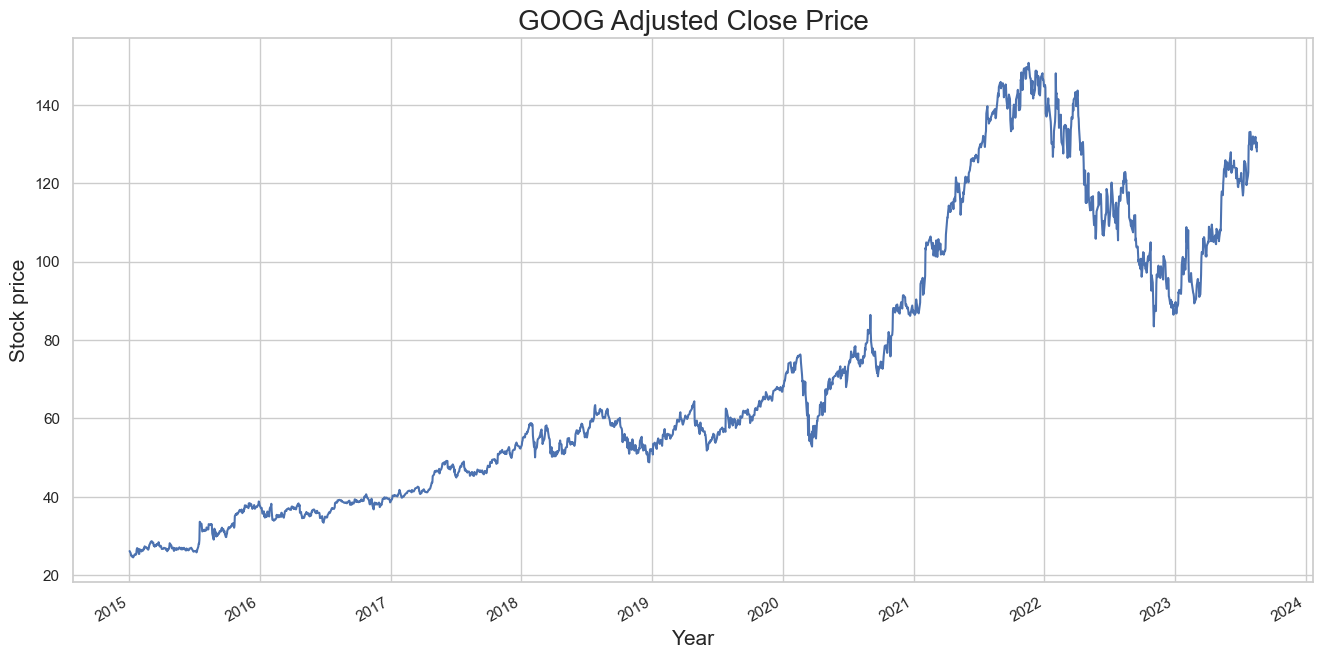

In [4]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Set the figure size
plt.figure(figsize=(16, 8))

# Plot the 'Adj Close' column from the DataFrame
df['Adj Close'].plot()

# Set plot title and labels
plt.title(f'{stock_name} Adjusted Close Price', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Stock price', fontsize=15)

In [5]:
# Create DataFrame for Adjusted Close price
df_adj = df[['Adj Close']]
df_adj

,Adj Close
Date,
2015-01-02,26.168653
2015-01-05,25.623152
2015-01-06,25.029282
2015-01-07,24.986401
2015-01-08,25.065184
...,...
2023-08-14,131.830002
2023-08-15,130.270004
2023-08-16,129.110001


# Creating Training Data Set and Feature Scalling

In [9]:
df_adj_arr = df_adj.values
training_data_len = int(0.8 * len(df_adj))
train = df_adj_arr[:training_data_len, :]

# Normalise the data
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train)

# train_scaled

train_scaled.shape

(1737, 1)

## Split training data into X_train, y_train

In [11]:
X_train = []
y_train = []
# Creating a data structure with 60 time-steps and 1 output
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i:i+1, 0])  
    if i <= 61:     # 60 days for first pass, 61 for second
      print(X_train)
      print(y_train)

[array([0.01275146, 0.0084272 , 0.00371951, 0.00337958, 0.00400411,
       0.00143089, 0.        , 0.00143484, 0.00328867, 0.00365231,
       0.00613857, 0.00567215, 0.01007548, 0.01653816, 0.01873587,
       0.01686228, 0.01030869, 0.00689749, 0.00715837, 0.01658955,
       0.01420212, 0.01450252, 0.01194116, 0.01384636, 0.0151982 ,
       0.01394519, 0.01754611, 0.0171627 , 0.01991378, 0.02231705,
       0.01987822, 0.01863706, 0.01989007, 0.01834061, 0.0155579 ,
       0.01721013, 0.02028535, 0.02487444, 0.02602864, 0.03114346,
       0.03205259, 0.03194586, 0.0327206 , 0.02969874, 0.03015924,
       0.02468868, 0.02317478, 0.02488631, 0.02164904, 0.02449103,
       0.02304039, 0.02646344, 0.02586659, 0.02680337, 0.0261907 ,
       0.03068889, 0.02618082, 0.02475193, 0.02205221, 0.02351077])]
[array([0.02191782])]
[array([0.01275146, 0.0084272 , 0.00371951, 0.00337958, 0.00400411,
       0.00143089, 0.        , 0.00143484, 0.00328867, 0.00365231,
       0.00613857, 0.00567215, 0.010

In [12]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1677, 60, 1)

## Train model

In [13]:
# Build the model - LSTM with 50 neurons and 4 hidden layers
model = Sequential()

# Adding the LSTM layers with Dropout regularisation
for _ in range(4):
    model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))

# Adding the final LSTM layer without return_sequences
model.add(LSTM(units=50, activation='tanh'))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fitting the model to the training set
model.fit(X_train, y_train, epochs=200, batch_size=64)

2023-08-21 20:20:26.398103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
27/27 [==============================] - 8s 106ms/step - loss: 0.0228
Epoch 2/200
27/27 [==============================] - 3s 102ms/step - loss: 0.0038
Epoch 3/200
27/27 [==============================] - 3s 101ms/step - loss: 0.0027
Epoch 4/200
27/27 [==============================] - 3s 101ms/step - loss: 0.0024
Epoch 5/200
27/27 [==============================] - 3s 104ms/step - loss: 0.0022
Epoch 6/200
27/27 [==============================] - 3s 104ms/step - loss: 0.0021
Epoch 7/200
27/27 [==============================] - 3s 102ms/step - loss: 0.0027
Epoch 8/200
27/27 [==============================] - 3s 102ms/step - loss: 0.0020
Epoch 9/200
27/27 [==============================] - 3s 100ms/step - loss: 0.0020
Epoch 10/200
27/27 [==============================] - 3s 103ms/step - loss: 0.0020
Epoch 11/200
27/27 [==============================] - 3s 102ms/step - loss: 0.0021
Epoch 12/200
27/27 [==============================] - 3s 103ms/step - loss: 0.0018
Epoch 13/200


27/27 [==============================] - 3s 101ms/step - loss: 7.3021e-04
Epoch 99/200
27/27 [==============================] - 3s 101ms/step - loss: 7.6985e-04
Epoch 100/200
27/27 [==============================] - 3s 102ms/step - loss: 7.6196e-04
Epoch 101/200
27/27 [==============================] - 3s 102ms/step - loss: 8.1467e-04
Epoch 102/200
27/27 [==============================] - 3s 102ms/step - loss: 6.8899e-04
Epoch 103/200
27/27 [==============================] - 3s 102ms/step - loss: 7.8736e-04
Epoch 104/200
27/27 [==============================] - 3s 102ms/step - loss: 8.5497e-04
Epoch 105/200
27/27 [==============================] - 3s 103ms/step - loss: 7.9994e-04
Epoch 106/200
27/27 [==============================] - 3s 102ms/step - loss: 0.0011
Epoch 107/200
27/27 [==============================] - 3s 101ms/step - loss: 8.8310e-04
Epoch 108/200
27/27 [==============================] - 3s 101ms/step - loss: 7.4390e-04
Epoch 109/200
27/27 [==============================

27/27 [==============================] - 3s 100ms/step - loss: 5.5072e-04
Epoch 192/200
27/27 [==============================] - 3s 101ms/step - loss: 5.3517e-04
Epoch 193/200
27/27 [==============================] - 3s 101ms/step - loss: 5.6913e-04
Epoch 194/200
27/27 [==============================] - 3s 101ms/step - loss: 6.4509e-04
Epoch 195/200
27/27 [==============================] - 3s 100ms/step - loss: 6.3822e-04
Epoch 196/200
27/27 [==============================] - 3s 101ms/step - loss: 6.3001e-04
Epoch 197/200
27/27 [==============================] - 3s 101ms/step - loss: 6.3019e-04
Epoch 198/200
27/27 [==============================] - 3s 100ms/step - loss: 5.6568e-04
Epoch 199/200
27/27 [==============================] - 3s 100ms/step - loss: 5.6501e-04
Epoch 200/200
27/27 [==============================] - 3s 101ms/step - loss: 5.5226e-04


In [14]:
test = df_adj_arr[training_data_len: , :]
inputs = df_adj_arr[len(df_adj_arr) - len(test) - 80:]
inputs = inputs.reshape(-1, 1)

# Scaling the data
inputs = scaler.transform(inputs)

# Initialize lists for X_test and y_test
X_test = []
y_test = df_adj_arr[training_data_len:, :]

# Create sequences of length 80 for X_test
for i in range(80, inputs.shape[0]):
    X_test.append(inputs[i - 80:i, 0])

In [15]:
# Convert data to numpy array
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # 3D
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

14/14 [==============================] - 2s 31ms/step


 ## RMSE

In [16]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)  
rmse

0.4223762775289601

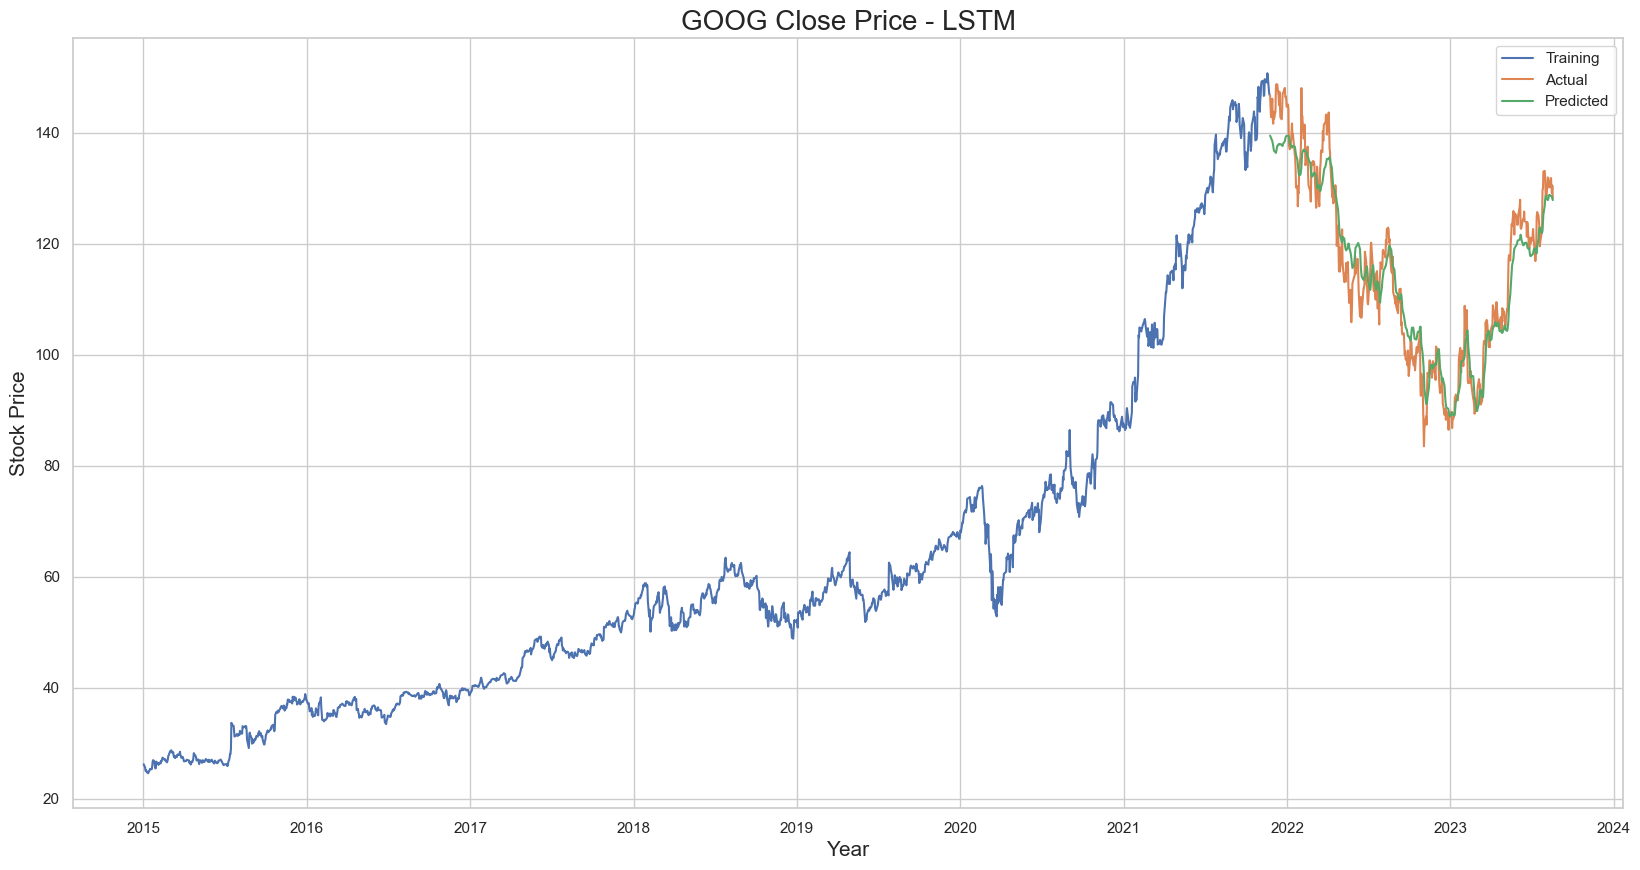

In [17]:
# Plot predicted vs actual values
train = df_adj[:training_data_len]
test = df_adj[training_data_len:]
test['Predictions'] = predictions

plt.figure(figsize=(20, 10))
sns.set_style("whitegrid")

plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')

plt.title("GOOG Close Price - LSTM", fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Stock Price', fontsize=15)
plt.legend()

plt.show()


In [18]:
test

,Adj Close,Predictions
Date,,
2021-11-24,146.717499,139.472382
2021-11-26,142.806000,139.084183
2021-11-29,146.113998,138.483994
2021-11-30,142.451996,138.082657
2021-12-01,141.617996,137.624115
...,...,...
2023-08-14,131.830002,128.598526
2023-08-15,130.270004,128.586929
2023-08-16,129.110001,128.474335


## Adjusted Closing Price Prediction

In [23]:

# Predict Adjusted Close price
stock_ = stock_name+".L"
quote = yf.download(stock_, start=start_date, end=end_date)
new_df = quote.filter(['Adj Close'])
prev_days = new_df[-80:].values
prev_days_scaled = scaler.transform(prev_days)
# Create empty list
X_test = [] 
X_test.append(prev_days_scaled)
# Convert the X_test data set to numpy array
X_test = np.array(X_test)
# Reshape data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get predicted price
pred_price = model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['GOOG.L']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.

In [24]:
# Actual price
# Get today's date
today = datetime.today()

# Calculate the previous day's date
previous_day = today - timedelta(days=1)

actual_price = yf.download("AZN.L", start=previous_day, end=end_date)
print(actual_price['Adj Close'])

[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['AZN.L']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-08-20 20:31:39.063084 -> 2023-08-21)')



Series([], Name: Adj Close, dtype: float64)
